In [27]:
import pandas as pd
import numpy as np
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
df = pd.read_csv("D:/repos/udemy/.dataset/winequality_red.csv", sep=';')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Normalizing the data
cols = df.columns.values.tolist()
cols.remove('quality')

In [5]:
df[cols] = df[cols].apply(stats.zscore)

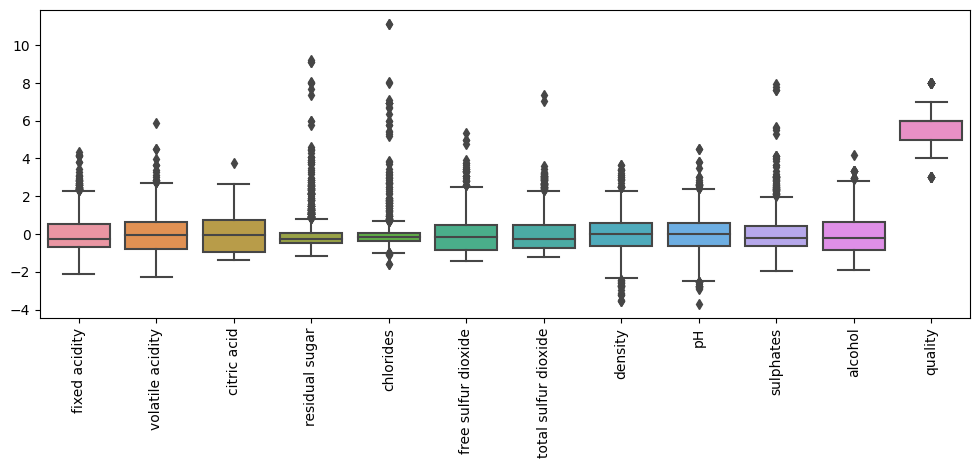

In [6]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

In [8]:
df['boolquality'] = np.where(df.quality>5, 1, 0)

In [9]:
tf_data = torch.tensor(df[cols].values).float()
tf_labels = torch.tensor(df.boolquality).float()
print(tf_data.shape)
print(tf_labels.shape)

torch.Size([1599, 11])
torch.Size([1599])


In [10]:
# We need to convert the labels to one dimensional tensor
tf_labels = tf_labels[:, None]
print(tf_labels.shape)

torch.Size([1599, 1])


In [11]:
x_train, x_test, y_train, y_test = train_test_split(tf_data, tf_labels, train_size=0.7)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

batch = 64
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [12]:
test_data.tensors[0].shape[0]

480

In [13]:
for x, y in train_loader:
    print(x.shape, y.shape)

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


# Model

In [39]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(11, 16)
        self.hidden1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.hidden2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.output = nn.Linear(20,1)
    def forward(self, x, doBN):
        # doBN is a do batch norm boolean
        x = F.relu(self.input(x))
        if doBN:
            x = self.bnorm1(x)
            x = F.relu(self.hidden1(x))
            x = self.bnorm2(x)
            x = F.relu(self.hidden2(x))
        else:
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [45]:
ann = model()

In [53]:
epochs = 1000
def train(doBN=True):
    # set the loss function and optimizer
    lossfn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ann.parameters(), lr=0.01)
    # initialize loss
    train_acc = []
    test_acc = []
    losses = []
    # triaining
    for i in range(epochs):
        ann.train()
        batchacc = []
        batchloss = []
        for xtrain, ytrain in train_loader:
            yhat = ann(xtrain, doBN)
            loss = lossfn(yhat, ytrain)
            batchloss.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # batch accuracy
            batchacc.append(100*torch.mean(((yhat>0) == ytrain).float()).item())
        # train accuracy
        train_acc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))
        # model evaluation
        ann.eval()
        xtest, ytest = next(iter(test_loader))
        with torch.no_grad():
            pred = ann(xtest, doBN)
        test_acc.append(100*torch.mean(((pred>0) == ytest).float()).item())

    return train_acc, test_acc, losses

In [54]:
train_acc, test_acc, losses = train(doBN=False)
train_acc_withbn, test_acc_withbn, losses_withbn = train(doBN=True)

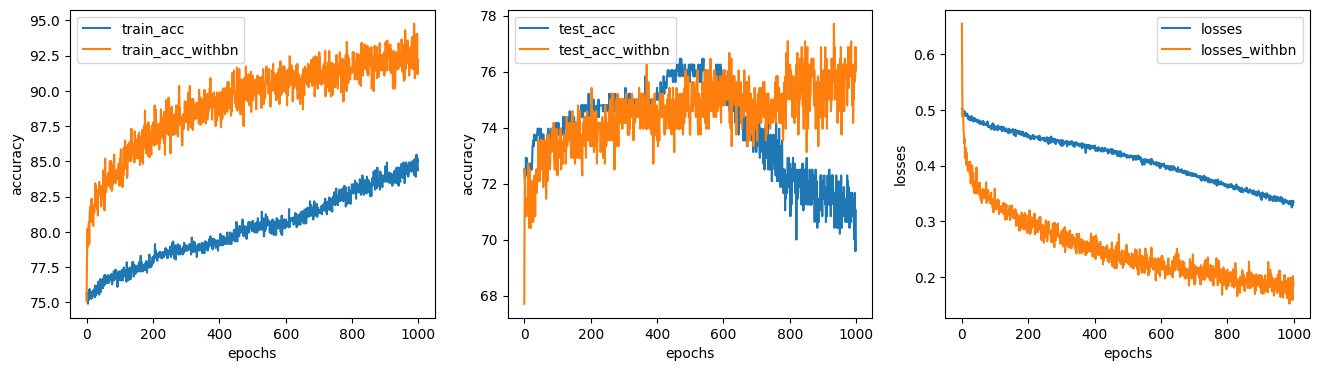

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].plot(range(epochs), train_acc)
ax[0].plot(range(epochs), train_acc_withbn)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
ax[0].legend(['train_acc', 'train_acc_withbn'])

ax[1].plot(range(epochs), test_acc)
ax[1].plot(range(epochs), test_acc_withbn)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend(['test_acc', 'test_acc_withbn'])


ax[2].plot(range(epochs), losses)
ax[2].plot(range(epochs), losses_withbn)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('losses')
ax[2].legend(['losses', 'losses_withbn'])